In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# File delle coppie generate dalla pipeline
matches_file = "matched_companies_detailed.csv"  # Nome del file generato
groundtruth_file = "data/ground_truth.csv"  # File della ground truth

# Caricamento dei dati
matches_df = pd.read_csv(matches_file)
groundtruth_df = pd.read_csv(groundtruth_file)

# Mostriamo le prime righe per confermare il caricamento
print("Esempio di matches_df:")
print(matches_df.head())

print("\nEsempio di groundtruth_df:")
print(groundtruth_df.head())


Esempio di matches_df:
   id_left  id_right  name_sim  industry_exact  city_exact  \
0       36         4  0.807407               1           0   
1       46        12  0.805556               1           0   
2       61        38  0.907692               0           0   
3       68        48  0.827547               1           0   
4       82        29  0.900000               0           0   

                        company_name_left industry_left  \
0                         IDFC FIRST Bank       Banking   
1                                Yes Bank       Banking   
2                           Bajaj Finance          NBFC   
3              Ujjivan Small Finance Bank       Banking   
4  Mahindra & Mahindra Financial Services          NBFC   

  headquarters_city_left       company_name_right industry_right  \
0                    NaN                HDFC Bank        Banking   
1                    NaN                Axis Bank        Banking   
2                    NaN            Bajaj Fin

Distribuzione delle Similarità Jaro-Winkler
Questo script genera un istogramma delle similarità tra le coppie trovate.

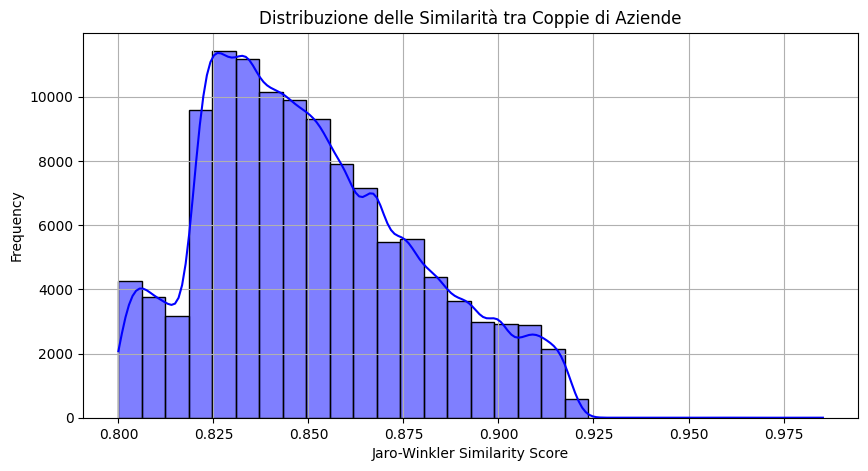

In [2]:
# Creazione del grafico di distribuzione delle similarità Jaro-Winkler
plt.figure(figsize=(10, 5))
sns.histplot(matches_df["name_sim"], bins=30, kde=True, color="blue")
plt.xlabel("Jaro-Winkler Similarity Score")
plt.ylabel("Frequency")
plt.title("Distribuzione delle Similarità tra Coppie di Aziende")
plt.grid()
plt.show()


Script 3: Confronto tra le pipeline
Questo script confronta il numero di coppie candidate, coppie filtrate e match finali.

<Figure size 1000x500 with 0 Axes>

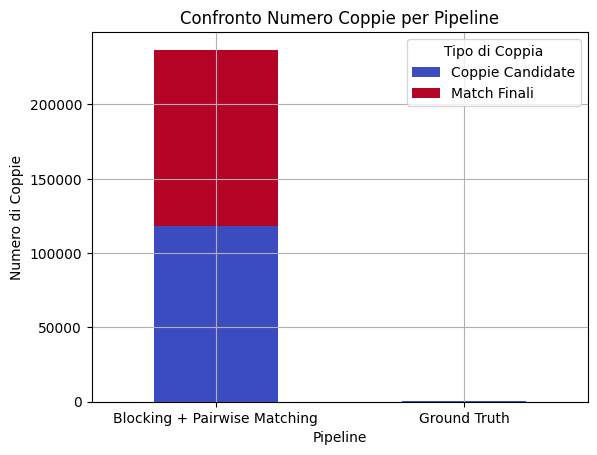

In [3]:
# Dati delle pipeline
pipeline_data = {
    "Pipeline": ["Blocking + Pairwise Matching", "Ground Truth"],
    "Coppie Candidate": [len(matches_df), len(groundtruth_df)],
    "Match Finali": [len(matches_df[matches_df["name_sim"] > 0.80]), len(groundtruth_df)]
}

# Creazione DataFrame per visualizzazione
df_pipeline = pd.DataFrame(pipeline_data)

# Grafico a barre
plt.figure(figsize=(10, 5))
df_pipeline.set_index("Pipeline").plot(kind="bar", stacked=True, colormap="coolwarm")
plt.xlabel("Pipeline")
plt.ylabel("Numero di Coppie")
plt.title("Confronto Numero Coppie per Pipeline")
plt.xticks(rotation=0)
plt.legend(title="Tipo di Coppia")
plt.grid()
plt.show()


Script 4: Confronto con la Ground Truth
Questo script calcola Precision, Recall, F1-score confrontando le coppie predette con la ground truth.


In [4]:
# Funzione per normalizzare i nomi delle aziende (rimuove spazi, lowercase)
def normalize_name(name):
    return name.strip().lower() if isinstance(name, str) else str(name).lower()

# Creiamo la colonna "normalized_pair" per le coppie (indipendentemente dall'ordine)
def normalize_pair(row, col1, col2):
    left = normalize_name(row[col1])
    right = normalize_name(row[col2])
    return tuple(sorted([left, right]))

# Creiamo le coppie normalizzate per il matching
matches_df["normalized_pair"] = matches_df.apply(lambda x: normalize_pair(x, "company_name_left", "company_name_right"), axis=1)
groundtruth_df["normalized_pair"] = groundtruth_df.apply(lambda x: normalize_pair(x, "company_a", "company_b"), axis=1)

# Creiamo gli insiemi
matches_set = set(matches_df["normalized_pair"])
groundtruth_set = set(groundtruth_df["normalized_pair"])
groundtruth_true_set = set(groundtruth_df[groundtruth_df["label"] == 1]["normalized_pair"])

# Calcoliamo TP, FP, FN
intersection = matches_set.intersection(groundtruth_set)
tp = len(intersection.intersection(groundtruth_true_set))  # True Positives
fp = len(intersection) - tp  # False Positives
fn = len(groundtruth_true_set) - tp  # False Negatives

# Calcolo metriche
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

# Stampa delle metriche
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1_score:.4f}")


Precision: 0.5034
Recall: 0.9125
F1-Score: 0.6489


Script 5: Grafico di Precision vs Recall
Questo script crea un grafico Precision-Recall Curve per valutare l'efficacia della pipeline.

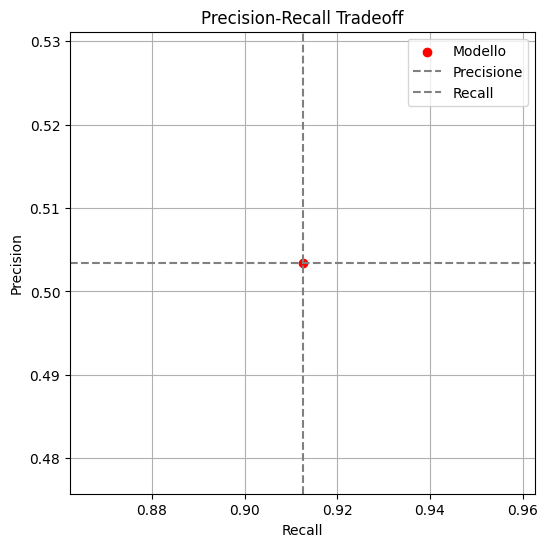

In [5]:
# Precision-Recall Curve
plt.figure(figsize=(6, 6))
plt.scatter(recall, precision, color="red", label="Modello")
plt.axhline(y=precision, color="gray", linestyle="--", label="Precisione")
plt.axvline(x=recall, color="gray", linestyle="--", label="Recall")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Tradeoff")
plt.legend()
plt.grid()
plt.show()


---
## Pipeline del Transformer


Script 1: Caricamento dei dati per la seconda pipeline

In [6]:
import pandas as pd

# File delle coppie predette dal modello Transformer
predicted_file = "entity-matching-transformer/matching_results.tsv"  # Output finale del modello
groundtruth_file = "data/ground_truth.csv"

# Caricamento dei dati
predicted_df = pd.read_csv(predicted_file, sep="\t")
groundtruth_df = pd.read_csv(groundtruth_file)

# Mostriamo le prime righe per verificare il caricamento
print("Esempio di predicted_df:")
print(predicted_df.head())

print("\nEsempio di groundtruth_df:")
print(groundtruth_df.head())


Esempio di predicted_df:
   id       sentence1    sentence2 label  match_score  predicted_label
0  42          Taxfix      Tipalti     ?     0.716715                1
1  42          Taxfix         Habi     ?     0.811081                1
2  48  LayerZero Labs  Notion Labs     ?     0.782600                1
3  53            Open          Opn     ?     0.757232                1
4  54          Genies     Personio     ?     0.719724                1

Esempio di groundtruth_df:
  company_a                                        industry_a country_a  \
0       1&1                       Telecommunication; Internet   Germany   
1     51job  Industries; Technology; Outsourcing and Staffing     China   
2  ABN AMRO                                        Financials       NaN   
3    AMPLUS                                        Technology     Japan   
4      Acer                                              Tech    Taiwan   

                     source_a           company_b  \
0  companiesMarke

Istogramma delle probabilità di matching del modello
Se il modello ha prodotto probabilità invece di solo 0/1, possiamo vedere la distribuzione.

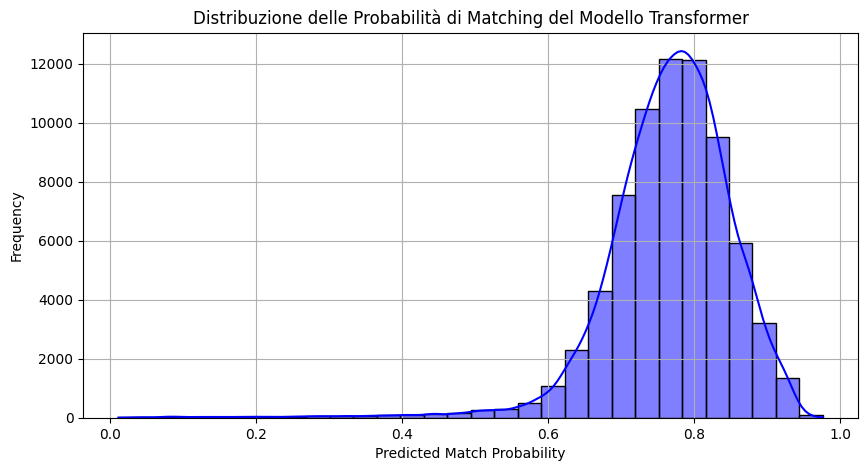

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Se il modello fornisce punteggi di probabilità (es. softmax output)
if "match_score" in predicted_df.columns:
    plt.figure(figsize=(10, 5))
    sns.histplot(predicted_df["match_score"], bins=30, kde=True, color="blue")
    plt.xlabel("Predicted Match Probability")
    plt.ylabel("Frequency")
    plt.title("Distribuzione delle Probabilità di Matching del Modello Transformer")
    plt.grid()
    plt.show()


Script 3: Confronto tra pipeline Transformer e Ground Truth
Qui confrontiamo il numero di coppie candidate e il numero di match finali.

<Figure size 1000x500 with 0 Axes>

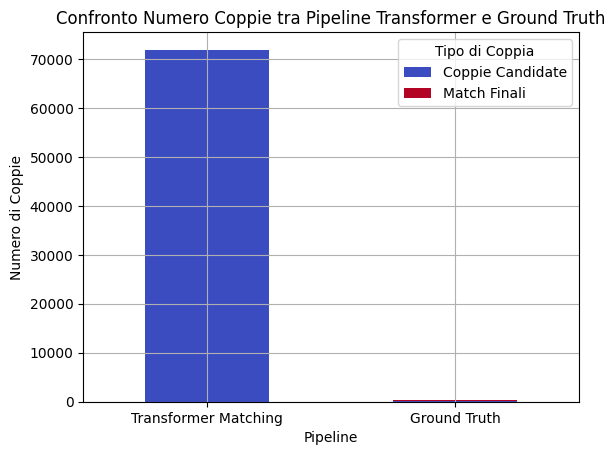

In [8]:
# Creazione DataFrame per confronto
pipeline_data = {
    "Pipeline": ["Transformer Matching", "Ground Truth"],
    "Coppie Candidate": [len(predicted_df), len(groundtruth_df)],
    "Match Finali": [len(predicted_df[predicted_df["label"] == 1]), len(groundtruth_df)]
}

df_pipeline = pd.DataFrame(pipeline_data)

# Grafico
plt.figure(figsize=(10, 5))
df_pipeline.set_index("Pipeline").plot(kind="bar", stacked=True, colormap="coolwarm")
plt.xlabel("Pipeline")
plt.ylabel("Numero di Coppie")
plt.title("Confronto Numero Coppie tra Pipeline Transformer e Ground Truth")
plt.xticks(rotation=0)
plt.legend(title="Tipo di Coppia")
plt.grid()
plt.show()


Script 4: Calcolo di Precision, Recall, F1-score

Numero di coppie predette come match dal modello: 1484
Numero di coppie in ground truth: 159
Numero di coppie in ground truth con label 1: 80
Numero di coppie in intersezione: 14
Numero di coppie corrette (True Positives): 11
📌 Precision: 0.7857
📌 Recall: 0.1375
📌 F1-Score: 0.2340


C:\Users\luca-\AppData\Local\Temp\ipykernel_24916\726129475.py:72: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Metric", y="Value", data=df_metrics, palette="viridis")


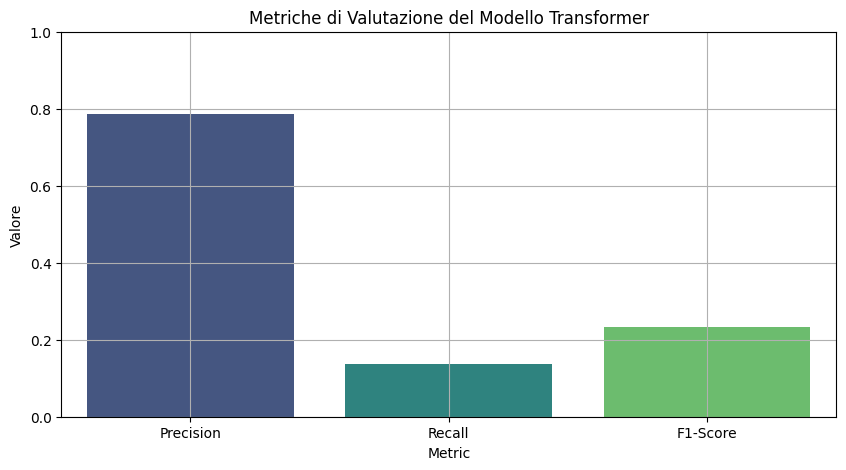

In [10]:
import pandas as pd

# 📂 Percorsi dei file (aggiorna con i percorsi reali)
model_output_file = "entity-matching-transformer/predicted_matches.tsv"  # File generato dal modello
groundtruth_file = "data/ground_truth.csv"  # Ground truth

# 📥 Caricamento dei file
model_results = pd.read_csv(model_output_file, sep="\t")
groundtruth = pd.read_csv(groundtruth_file)

# 🔍 Normalizzazione dei nomi di società (rimuove spazi e usa lowercase)
def normalize_name(name):
    return name.strip().lower() if isinstance(name, str) else str(name).lower()

# 📌 Funzione per ottenere una tupla ordinata, così che l'ordine non conti
def normalize_pair(row, col1, col2):
    left = normalize_name(row[col1])
    right = normalize_name(row[col2])
    return tuple(sorted([left, right]))

# 📊 Filtriamo solo le coppie che il modello ha predetto come match (label 1)
model_results = model_results[model_results["label"] == 1]

# 🛠 Creiamo la colonna 'normalized_pair' nei dataset
model_results["normalized_pair"] = model_results.apply(
    lambda x: normalize_pair(x, "sentence1", "sentence2"), axis=1
)
groundtruth["normalized_pair"] = groundtruth.apply(
    lambda x: normalize_pair(x, "company_a", "company_b"), axis=1
)

# 🔀 Convertiamo in insiemi per confronto
model_set = set(model_results["normalized_pair"])
groundtruth_set = set(groundtruth["normalized_pair"])

# 🔗 Intersezione tra le coppie predette e quelle nella ground truth
intersection = model_set.intersection(groundtruth_set)

# 🎯 Filtriamo la ground truth per ottenere solo i veri match (label = 1)
groundtruth_true_set = set(groundtruth[groundtruth["label"] == 1]["normalized_pair"])

# ✅ Calcoliamo il numero di True Positives (coppie predette che sono davvero match)
tp = len(intersection.intersection(groundtruth_true_set))

# 📊 Calcolo delle metriche:
precision = tp / len(intersection) if len(intersection) else 0
recall = tp / len(groundtruth_true_set) if len(groundtruth_true_set) else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) else 0

# 📢 Output dei risultati
print(f"Numero di coppie predette come match dal modello: {len(model_set)}")
print(f"Numero di coppie in ground truth: {len(groundtruth_set)}")
print(f"Numero di coppie in ground truth con label 1: {len(groundtruth_true_set)}")
print(f"Numero di coppie in intersezione: {len(intersection)}")
print(f"Numero di coppie corrette (True Positives): {tp}")
print(f"📌 Precision: {precision:.4f}")
print(f"📌 Recall: {recall:.4f}")
print(f"📌 F1-Score: {f1_score:.4f}")

# Aggiorniamo il DataFrame df_pipeline con i nuovi valori di precision, recall e f1_score
df_pipeline.loc[df_pipeline["Pipeline"] == "Transformer Matching", "Match Finali"] = tp

# Grafico Precision, Recall, F1-Score
metrics_data = {
    "Metric": ["Precision", "Recall", "F1-Score"],
    "Value": [precision, recall, f1_score]
}

df_metrics = pd.DataFrame(metrics_data)

plt.figure(figsize=(10, 5))
sns.barplot(x="Metric", y="Value", data=df_metrics, palette="viridis")
plt.ylim(0, 1)
plt.title("Metriche di Valutazione del Modello Transformer")
plt.ylabel("Valore")
plt.grid()
plt.show()

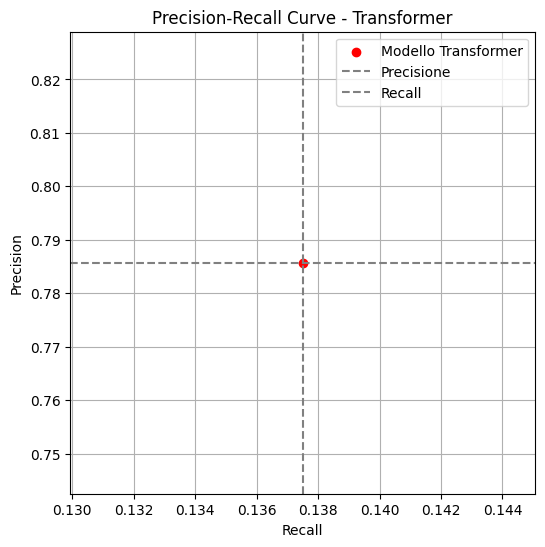

In [ ]:
# Precision-Recall Curve
plt.figure(figsize=(6, 6))
plt.scatter(recall, precision, color="red", label="Modello Transformer")
plt.axhline(y=precision, color="gray", linestyle="--", label="Precisione")
plt.axvline(x=recall, color="gray", linestyle="--", label="Recall")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve - Transformer")
plt.legend()
plt.grid()
plt.show()
